<center>

# **Monitoramento da Superfície Hídrica de Reservatórios do Estado da Paraíba Utilizando *Deep Learning* e Imagens de Satélite** 

**Ariane Marina de Albuquerque Teixeira**

**Projeto Final - Deep Learning - PPGI - UFPB**

**2022**





# **SUMÁRIO**

1. Set Up
2. Carregando e Visualizando os Dados
3. Criando o Modelo
4. Testando o Modelo
5. Monitoramento da Superfície Hídrica de Reservatórios
6. Referências

# **1) SET UP**

**Google Drive**

In [1]:
### mount on google drive if you use colab
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/water_monitoring")

Mounted at /content/drive/


**Importando as bibliotecas necessárias**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime 
import os
from os import chdir, getcwd, listdir
from os.path import isfile 
from osgeo import gdal, osr
import glob
import re
import seaborn as sns
sns.set_theme(style='darkgrid')

import cv2

import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score

# **2. CARREGANDO E VISUALIZANDO DADOS**




**Funções para o processamento das imagens do conjunto de dados**

In [3]:
# Converter uma Imagem no formato Tiff de uma banda para uma numpy usando gdal
def readTiffImage1Band(fname):
    tif = gdal.Open(fname)
    img = tif.ReadAsArray()
    return img

In [4]:
# Converter uma Imagem no formato Tiff de seis bandas para uma numpy usando gdal
def readTiffImage6Band(fname):
    tif = gdal.Open(fname)
    img = tif.ReadAsArray()
    img = np.stack((img[0], img[1], img[2], img[3], img[4], img[5]), axis=-1)
    img = np.clip(img/10000,0,1)  #normalização das imagens
    return img

In [5]:
# Preenchimento na parte inferior e à esquerda das imagens para poder cortar em imagens de 128x128 para treinamento
def padding(img, w, h, crop_size, stride, n_h, n_w, c=None):

    if h % stride != 0:
      j = int(h/stride)
      i = j + 1
      h_toadd= i*stride-h 
    else:
      h_toadd= 0

    if w % stride != 0:
      j = int(w/stride)
      i = j + 1
      w_toadd= i*stride-w 
    else:
      w_toadd= 0

    if(c == None):
        img_pad = np.pad(
            img, [(0, h_toadd), (0, w_toadd)], mode='constant')
    else:

        img_pad = np.pad(
            img, [(0, h_toadd), (0, w_toadd), (0, 0)], mode='constant')

    return img_pad

In [6]:
# Cortando a imagem em crop_size*crop_size 
def crops(a, crop_size=128):

    stride = 128

    croped_images = []

    # 1 Banda
    if(len(a.shape) == 2):
        h, w = a.shape

        n_h = int(int(h/stride))
        n_w = int(int(w/stride))

        # Adicionando pixels conforme necessário
        a = padding(a, w, h, crop_size, stride, n_h, n_w)

        # Cortando a imagem em cortes de 128*128 com um passo de 128
        for i in range(n_h-1):
            for j in range(n_w-1):
                crop_x = a[(i*stride):((i*stride)+crop_size),
                           (j*stride):((j*stride)+crop_size)]
                crop_x = crop_x[..., np.newaxis]
                croped_images.append(crop_x)
    else:

        # 6 Bandas

        h, w, c = a.shape
        n_h = int(int(h/stride))
        n_w = int(int(w/stride))

        # Adicionando pixels conforme necessário
        a = padding(a, w, h, crop_size, stride, n_h, n_w, c)

        # Cortando a imagem em cortes de 128*128 com um passo de 128
        for i in range(n_h-1):
            for j in range(n_w-1):
                crop_x = a[(i*stride):((i*stride)+crop_size),
                           (j*stride):((j*stride)+crop_size), :]
                croped_images.append(crop_x)

    return croped_images

In [7]:
def flip(list_train):
  images_flip = []
  for name in list_train:
    image = np.flipud(name)
    images_flip.append(image)
  
  return images_flip

In [8]:
def getCroppedImages1Band(filelist_train):
    train_list_cropped = []

    for fname in filelist_train:
        # Lendo a Imagem
        image = readTiffImage1Band(fname)
        # Preenchendo a imagem e realizando o corte
        crops_list = crops(image)
        train_list_cropped = train_list_cropped + crops_list
    
    # Flip vertical de todas as imagens
    images_flip= flip(train_list_cropped)
    train_list_cropped = train_list_cropped + images_flip
    
    # Array com todas as imagens 
    train_cropped = np.asarray(train_list_cropped)
    del train_list_cropped
    return train_cropped

In [9]:
def getCroppedImagesMorethan1Band(filelist_train):
    train_list_cropped = []

    for fname in filelist_train:
        # Lendo a imagem
        image = readTiffImage6Band(fname)
        # Preenchendo a imagem e realizando o corte
        crops_list = crops(image)
        train_list_cropped = train_list_cropped + crops_list

    # Flip vertical de todas as imagens
    images_flip= flip(train_list_cropped)
    train_list_cropped = train_list_cropped + images_flip
    
    # Array com todas as imagens 
    train_cropped = np.asarray(train_list_cropped)
    del train_list_cropped
    return train_cropped

**Obtendo as imagens do conjunto de dados**

In [11]:
# Lista das imagens de satélite do dataset
filelist_x = sorted(glob.glob('/content/drive/My Drive/water_monitoring/data/scene/*'))
print(str(len(filelist_x))+" imagens de satélites encontradas.")

95 imagens de satélites encontradas.


In [12]:
# Lista das máscaras de água das imagens de satélite do dataset
filelist_y = sorted(glob.glob('/content/drive/My Drive/water_monitoring/data/truth/*'))
print(str(len(filelist_y))+" máscaras de água encontradas.")

95 máscaras de água encontradas.


In [13]:
# Lendo, preenchendo, recortando e criando uma matriz de todas as imagens recortadas de todas as imagens do dataset
dataset_x = getCroppedImagesMorethan1Band(filelist_x)
print("DatasetX Images: "+str(dataset_x.shape))

DatasetX Images: (7600, 128, 128, 6)


In [14]:
# Lendo, preenchendo, recortando e criando uma matriz de todas as imagens recortadas de todas as images de máscara de água do dataset
dataset_y = getCroppedImages1Band(filelist_y)
print("DatasetY Images: "+str(dataset_y.shape))

DatasetY Images: (7600, 128, 128, 1)


In [15]:
#Salvando o conjunto de dados
np.save('data/dataset_scene.npy', dataset_x)
print("Saved X")
np.save('data/dataset_truth.npy', dataset_y)
print("Saved Y")

Saved X
Saved Y


**Carregando o conjunto de dados salvo**

In [10]:
dataset_x = np.load('/content/drive/My Drive/water_monitoring/data/dataset_scene.npy')
print("DatasetX Images: "+str(dataset_x.shape))

dataset_y = np.load('/content/drive/My Drive/water_monitoring/data/dataset_truth.npy')
print("DatasetY Images: "+str(dataset_y.shape))

DatasetX Images: (7600, 128, 128, 6)
DatasetY Images: (7600, 128, 128, 1)


**Visualizando as imagens do dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


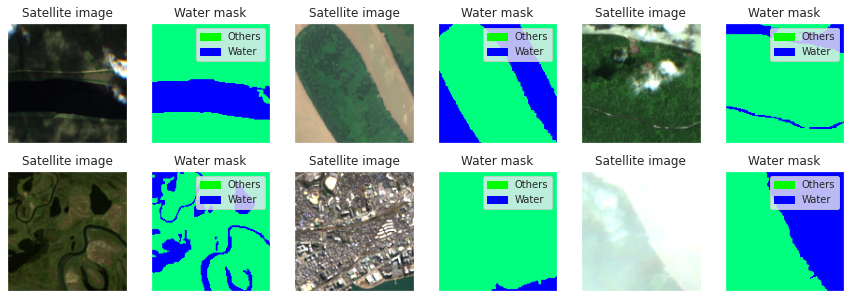

In [12]:
#Visualizando as imagens do dataset
plt.figure(figsize=(15,5))
i=1
for x in range(6):  
  indice= random.randint(0, len(dataset_x)-1)
  plt.subplot(2,6,i)
  plt.title('Satellite image')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(dataset_x[indice][:, :, (2,1,0)]*5)
  i+=1
  plt.subplot(2,6,i)
  plt.title('Water mask')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  GNColor = mpatches.Patch(color='#00FF00', label='Others')
  BLColor = mpatches.Patch(color='blue', label='Water')
  plt.legend(handles=[GNColor,BLColor],prop={'size': 10})
  plt.imshow(dataset_y[indice][:,:,0], cmap='winter_r')
  i+=1
plt.show()

**Dividindo o dataset entre teste e treino** 

In [13]:
(test_images, test_mask) = dataset_x[0:760], dataset_y[0:760]
(train_images, train_mask) = dataset_x[760:], dataset_y[760:]

print('Imagens de satélite para treinamento:', train_images.shape)
print('Máscaras de água para treinamento:', train_mask.shape,'\n')

print('Imagens de satélites para teste:', test_images.shape)
print('Máscaras de água para teste:', test_mask.shape)

Imagens de satélite para treinamento: (6840, 128, 128, 6)
Máscaras de água para treinamento: (6840, 128, 128, 1) 

Imagens de satélites para teste: (760, 128, 128, 6)
Máscaras de água para teste: (760, 128, 128, 1)


# **3. CRIANDO O MODELO**

**Definindo a arquitetura da rede**

In [14]:
#Function to build U-Net network architecture. 
#Used https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb as template.

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
    
def get_unet(input_img, n_filters, dropout, batchnorm):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [16]:
input_img = Input((None, None, 6), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5),tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, None, None,  0           []                               
                                 6)]                                                              
                                                                                                  
 conv2d_20 (Conv2D)             (None, None, None,   880         ['img[0][0]']                    
                                16)                                                               
                                                                                                  
 batch_normalization_19 (BatchN  (None, None, None,   64         ['conv2d_20[0][0]']              
 ormalization)                  16)                                                         

**Treinamento do Modelo**

In [16]:
results = model.fit(train_images, train_mask, 
                    batch_size=32, 
                    epochs=50, 
                    validation_split=0.2
                    )

print('Treinamento completo!!')

Epoch 1/50
171/171 [==============================] - 33s 98ms/step - loss: 0.2131 - binary_io_u: 0.8938 - recall: 0.9482 - precision: 0.8803 - val_loss: 0.6459 - val_binary_io_u: 0.3657 - val_recall: 0.0024 - val_precision: 0.1169
Epoch 2/50
171/171 [==============================] - 13s 75ms/step - loss: 0.0907 - binary_io_u: 0.9462 - recall: 0.9578 - precision: 0.9560 - val_loss: 0.6153 - val_binary_io_u: 0.5159 - val_recall: 0.2533 - val_precision: 0.9442
Epoch 3/50
171/171 [==============================] - 13s 74ms/step - loss: 0.0636 - binary_io_u: 0.9525 - recall: 0.9603 - precision: 0.9639 - val_loss: 0.1992 - val_binary_io_u: 0.7575 - val_recall: 0.6468 - val_precision: 0.9719
Epoch 4/50
171/171 [==============================] - 13s 74ms/step - loss: 0.0551 - binary_io_u: 0.9543 - recall: 0.9645 - precision: 0.9627 - val_loss: 0.0493 - val_binary_io_u: 0.9603 - val_recall: 0.9599 - val_precision: 0.9803
Epoch 5/50
171/171 [==============================] - 13s 75ms/step - lo

In [17]:
#listando todos os dados do treinamento do modelo
print(results.history.keys())

dict_keys(['loss', 'binary_io_u', 'recall', 'precision', 'val_loss', 'val_binary_io_u', 'val_recall', 'val_precision'])


**Salvando o modelo**

In [18]:
model.save("/content/drive/My Drive/water_monitoring/model/trained_model.h5")

**Verificando a performance do modelo**

<function matplotlib.pyplot.show>

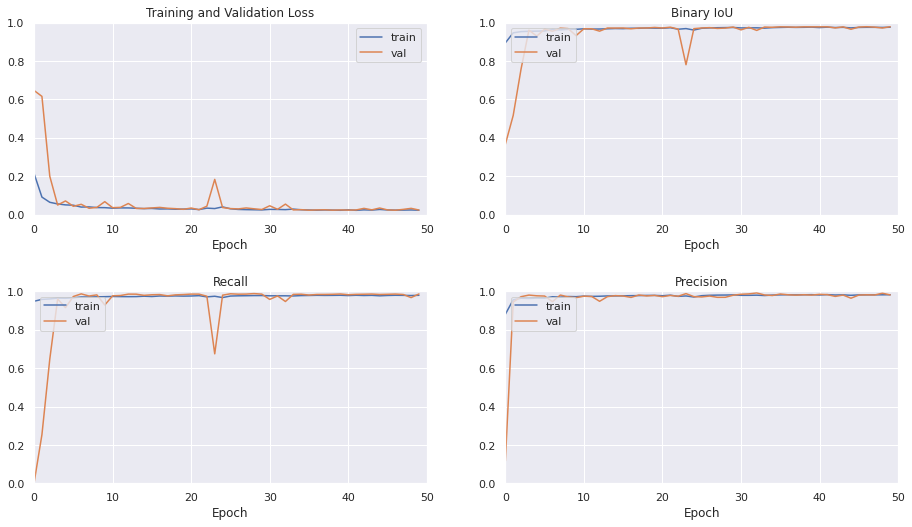

In [38]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'],label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xlim([0, 50])
plt.legend()

plt.subplot(2,2,2)
plt.plot(results.history['binary_io_u'])
plt.plot(results.history['val_binary_io_u'])
plt.title('Binary IoU')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xlim([0, 50])
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2,2,3)
plt.plot(results.history['recall'])
plt.plot(results.history['val_recall'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xlim([0, 50])
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2,2,4)
plt.plot(results.history['precision'])
plt.plot(results.history['val_precision'])
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xlim([0, 50])
plt.legend(['train', 'val'], loc='upper left')

plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.2,  
                    hspace=0.4)

plt.show

**Avaliando o modelo no conjunto de teste**

In [39]:
y_pred = model.predict(test_images)
y_pred = np.where(y_pred > 0.5, 1, 0)

In [40]:
precisao = jaccard_score(test_mask.flatten(), y_pred.flatten())
print("Métrica Binary IoU do modelo no conjunto de teste:", np.round(precisao*100,2),'%')

Métrica do modelo no conjunto de teste: 95.19 %


In [41]:
# Avaliando o modelo no conjunto de teste
# model.evaluate(test_images, test_mask, verbose=1)

24/24 [==============================] - 1s 29ms/step - loss: 0.0281 - binary_io_u: 0.9685 - recall: 0.9773 - precision: 0.9734


[0.028134021908044815,
 0.968525767326355,
 0.9773435592651367,
 0.9733687043190002]

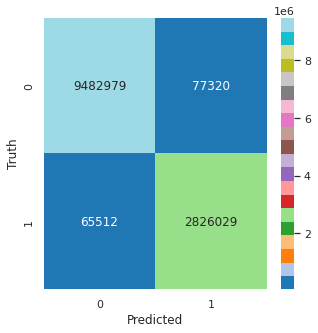

In [43]:
#Matriz de confusão
cm = tf.math.confusion_matrix(test_mask.flatten(), y_pred.flatten())
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True, fmt='d',cmap="tab20")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

**Verificando o desempenho do modelo no conjunto de teste**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


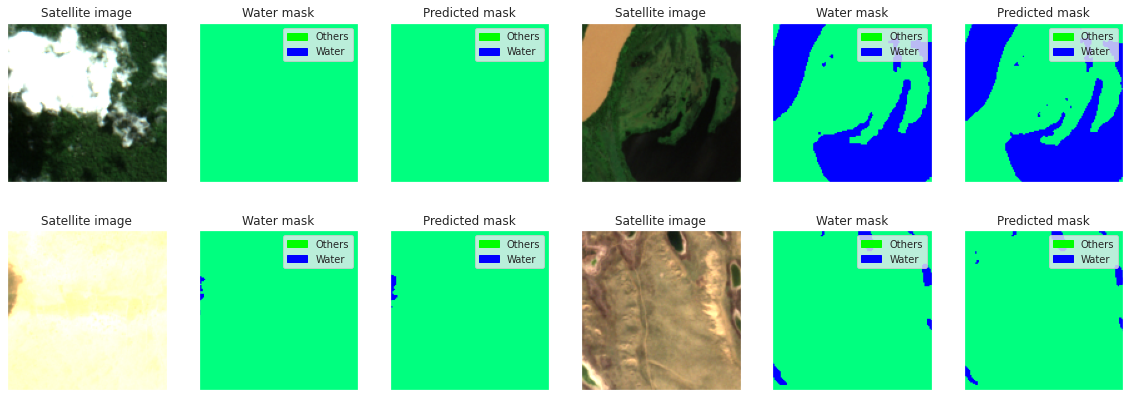

In [45]:
plt.figure(figsize=(20,7))

i=1
for x in range(4):
  indice= random.randint(0, len(test_images)-1)  

  plt.subplot(2,6,i)
  plt.title('Satellite image')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow((test_images[indice])[:, :, (2,1,0)]*5)

  i+=1
  plt.subplot(2,6,i)
  plt.title('Water mask')
  GNColor = mpatches.Patch(color='#00FF00', label='Others')
  BLColor = mpatches.Patch(color='blue', label='Water')
  plt.legend(handles=[GNColor,BLColor],prop={'size': 10})
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_mask[indice][:,:,0],cmap='winter_r')

  newimg = (test_images[indice]).reshape(1, 128, 128, 6)
  y_pred= model.predict(newimg)
  y_pred = (y_pred).reshape(128, 128, 1)  
  water_map = np.where(y_pred>0.6, 1, 0)
  i+=1
  plt.subplot(2,6,i)
  plt.title('Predicted mask')
  GNColor = mpatches.Patch(color='#00FF00', label='Others')
  BLColor = mpatches.Patch(color='blue', label='Water')
  plt.legend(handles=[GNColor,BLColor],prop={'size': 10})
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(water_map[:,:,0],cmap='winter_r')
  i+=1

plt.show()

# **4. TESTANDO O MODELO**

**Carregando o modelo treinado**

In [18]:
model.load_weights('/content/drive/My Drive/water_monitoring/model/trained_model.h5')

**Carregando um conjunto de imagens**

In [17]:
# Lista das Imagens de Satellite para teste do modelo
filelist = sorted(glob.glob('/content/drive/My Drive/water_monitoring/data/*.tif'))

In [18]:
print(str(len(filelist))+" imagens encontradas.")

1 imagens encontradas.


**Predição das imagens**

In [19]:
#Função para realizar a predição das imagens
def predict(filelist):
  array = []
  for fname in filelist:
    # Lendo a imagem
    image = readTiffImage6Band(fname)

    h, w, c = image.shape

    # Processando a image
    crop_size = 128
    stride = 128
    n_h = int(int(h/stride))
    n_w = int(int(w/stride))
    image = padding(image, w, h, crop_size, stride, n_h, n_w, c)

    h2, w2, c = image.shape
    
    # Forma um array de uma imagem
    # Isso é feito porque o modelo recebe uma matriz de imagens como entrada.
    item = np.reshape(image, (1, h2, w2, c))

    y_pred= model.predict(item)
    y_pred = (y_pred).reshape(h2, w2, 1)
    y_pred = y_pred[:h, :w, :]
    water_map = np.where(y_pred>0.5, 1, 0)

    array.append(water_map)

  array = np.asarray(array)  

  return array

In [20]:
imagens = predict(filelist)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


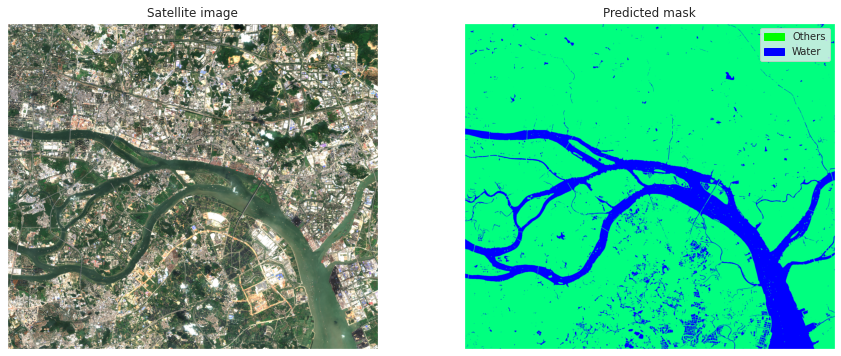

In [21]:
#Visualizando as imagens e mascara prevista
plt.figure(figsize=(15,6))

j=0
for i in imagens:
  image = readTiffImage6Band(filelist[j])
  j+=1
  plt.subplot(1,2,1)
  plt.title('Satellite image')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([]) 
  plt.imshow(image[:, :, (2,1,0)]*5)

  plt.subplot(1,2,2)
  plt.title('pred')
  plt.imshow(i[:,:,0],cmap='winter_r')
  plt.title('Predicted mask')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  GNColor = mpatches.Patch(color='#00FF00', label='Others')
  BLColor = mpatches.Patch(color='blue', label='Water')
  plt.legend(handles=[GNColor,BLColor],prop={'size': 10})
  plt.imshow(i[:,:,0], cmap='winter_r')

plt.show()

# **5. MONITORAMENTO DA SUPERFÍCIE HÍDRICA DE RESERVATÓRIOS**

In [20]:
#Função para visualizar a predição de uma imagem aleatória do conjunto de imagens do açude
def randomPrediction(filelist,masks):
  indice= random.randint(0, len(masks)-1)

  plt.figure(figsize=(12,6))
  image = readTiffImage6Band(filelist[indice])
  plt.subplot(1,2,1)
  plt.title('Satellite image')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([]) 
  plt.imshow(image[:, :, (2,1,0)]*5)

  plt.subplot(1,2,2)
  plt.title('pred')
  plt.imshow(masks[indice][:,:,0],cmap='winter_r')
  plt.title('Predicted mask')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  GNColor = mpatches.Patch(color='#00FF00', label='Others')
  BLColor = mpatches.Patch(color='blue', label='Water')
  plt.legend(handles=[GNColor,BLColor],prop={'size': 10})
  plt.imshow(masks[indice][:,:,0], cmap='winter_r')

In [21]:
#Função para gerar o gráfico de monitoramento
def waterMonitoring(filelist,masks,name,lim_inf_y,lim_sup_y):

  #contando os pixels de água nas mascaras preditas
  pixel_water=[]
  for i in masks:
    number_of_blue_pix = np.sum(i == 1) 
    pixel_water.append(number_of_blue_pix)

  #como cada pixel equivale a uma área de 10mx10m da imagens
  area_water = (np.asarray(pixel_water)*100/100000)  

  #salvando as datas de cada imagem
  dates = []
  for i in filelist:
    data = re.split('/content/drive/My Drive/water_monitoring/data/acudes/.*/(.*)',i)[1]
    dates.append(datetime(int(data[0:4]),int(data[4:6]),int(data[6:8])))
  
  #gerando o gráfico
  plt.figure(figsize=(9, 5))
  plt.plot(dates, area_water)
  plt.fill_between(dates, area_water,alpha = 0.2, where=(area_water>0))
  plt.title('MONITORAMENTO DA SUPERFÍCIE HÍDRICA ' + name,fontsize=15)
  plt.xlabel('ANO')
  plt.ylabel('ÁREA DE SUPERFÍCIE ÁGUA (.10⁶ m²)')
  plt.ylim([lim_inf_y,lim_sup_y])
  plt.xticks(rotation=45)
    
  plt.show()

**Açude Engenheiro Ávidos**

In [68]:
# Lista das imagens de satélite do açude Engenheiro Ávidos
filelist_avidos = sorted(glob.glob('/content/drive/My Drive/water_monitoring/data/acudes/avidos/*.tif'))
print(str(len(filelist_avidos))+" imagens encontradas.")

76 imagens encontradas.


In [69]:
#Realizando a predição das imagens
water_masks_avidos = predict(filelist_avidos)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


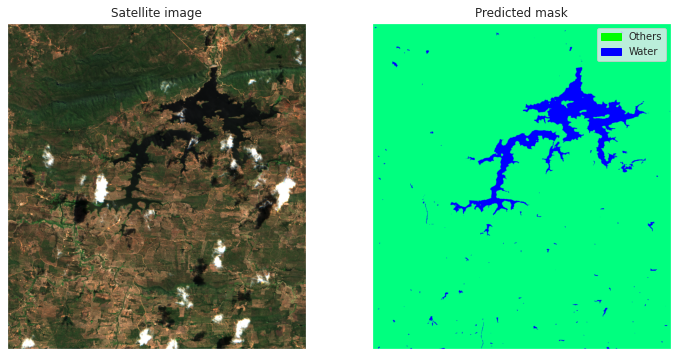

In [38]:
#Visualizando uma imagem aleatória do açude
randomPrediction(filelist_avidos,water_masks_avidos)

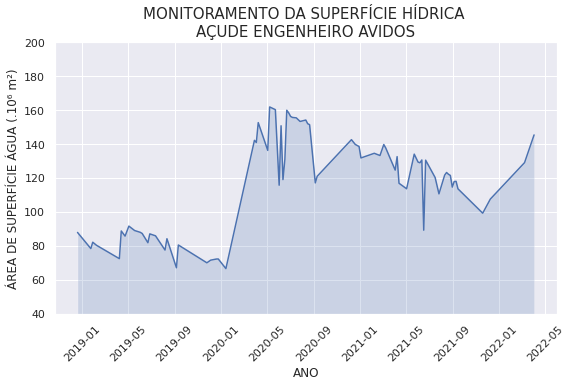

In [107]:
#Gerando o gráfico de monitoramento da superfície hidrica
waterMonitoring(filelist_avidos,water_masks_avidos,'\nAÇUDE ENGENHEIRO AVIDOS', 40,200)

**Açude Argemiro de Figueiredo (Acauã)**

In [20]:
# Lista das imagens de satélite do Açude Acaua
filelist_acaua = sorted(glob.glob('/content/drive/My Drive/water_monitoring/data/acudes/acaua/*.tif'))
print(str(len(filelist_acaua))+" imagens encontradas.")

32 imagens encontradas.


In [23]:
#Realizando a predição das imagens
water_masks_acaua = predict(filelist_acaua)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


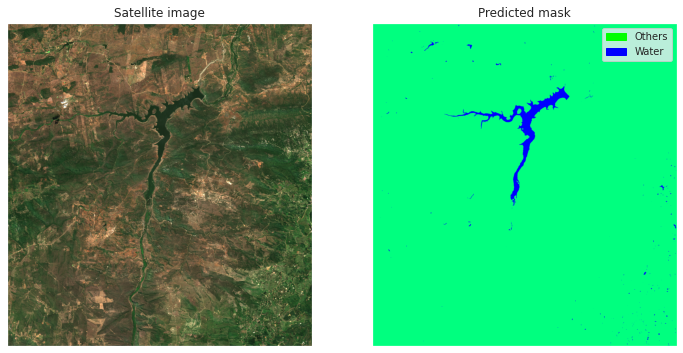

In [28]:
#Visualizando uma imagem aleatória do açude
randomPrediction(filelist_acaua,water_masks_acaua)

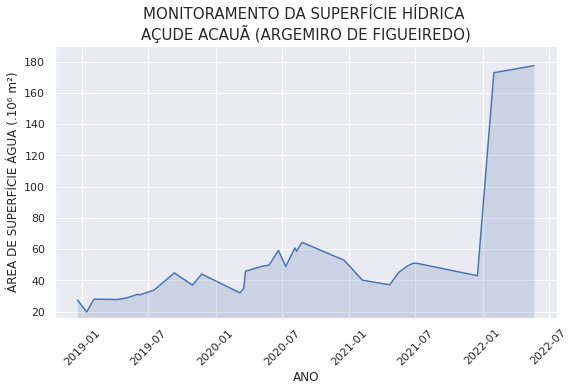

In [110]:
#Gerando o gráfico de monitoramento da superfície hídrica
waterMonitoring(filelist_acaua,water_masks_acaua,'\nAÇUDE ACAUÃ (ARGEMIRO DE FIGUEIREDO)',16,190)

**Açude Lagoa do Arroz**

In [22]:
# Lista das imagens de satélite do açude lagoa do arroz
filelist_arroz = sorted(glob.glob('/content/drive/My Drive/water_monitoring/data/acudes/arroz/*.tif'))
print(str(len(filelist_arroz))+" imagens encontradas.")

89 imagens encontradas.


In [23]:
#Realizando a predição das imagens do açude
water_masks_arroz = predict(filelist_arroz)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


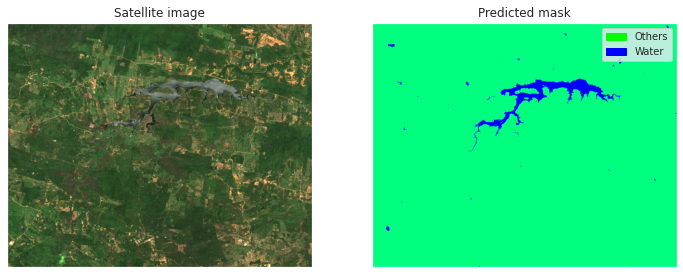

In [24]:
#Visualizando uma imagem aleatória do açude
randomPrediction(filelist_arroz,water_masks_arroz)

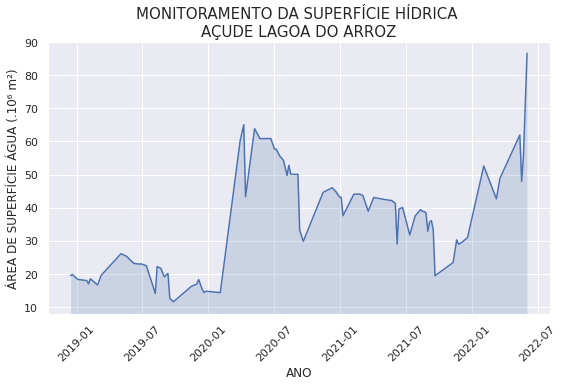

In [108]:
#Gerando o gráfico de monitoramento da superfície hídrica do açude
waterMonitoring(filelist_arroz,water_masks_arroz,'\nAÇUDE LAGOA DO ARROZ',8,90)

**Açude Gramame/Mamuaba**

In [38]:
# Lista das imagens de satélite do açude gramame-mamuaba
filelist_gramame = sorted(glob.glob('/content/drive/My Drive/water_monitoring/data/acudes/gramame/*.tif'))
print(str(len(filelist_gramame))+" imagens encontradas.")

67 imagens encontradas.


In [39]:
#Realizando a predição das imagens do açude
water_masks_gramame = predict(filelist_gramame)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


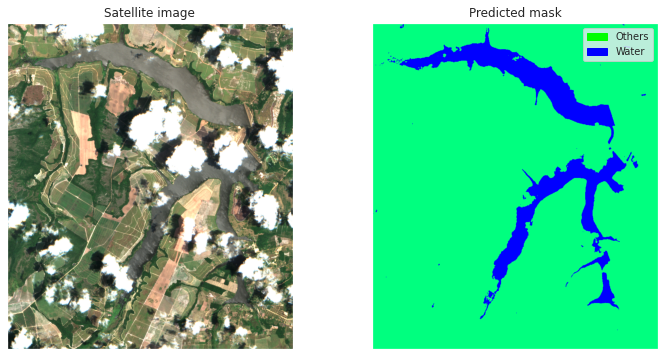

In [44]:
#Visualizando uma imagem aleatória do açude
randomPrediction(filelist_gramame,water_masks_gramame)

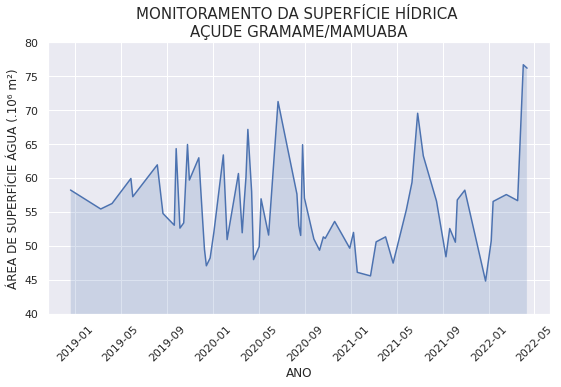

In [111]:
#Gerando o gráfico de monitoramento da superfície hídrica do açude
waterMonitoring(filelist_gramame,water_masks_gramame,'\nAÇUDE GRAMAME/MAMUABA',40,80)

# **6. REFERÊNCIAS**

1. [Ronneberger et al. (2015)'s U-Net](https://arxiv.org/abs/1505.04597)
2. [Understanding Semantic Segmentation with UNET](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)
3. [An applicable and automatic method for earth surface water mapping based on multispectral images. International Journal of Applied Earth Observation and Geoinformation](https://www.sciencedirect.com/science/article/pii/S0303243421001793)
4. [Monitoramento - Reservatórios Hídricos - AESA](http://www.aesa.pb.gov.br/aesa-website/monitoramento/ultimos-volumes/)
5. [Metrics to Evaluate your Semantic Segmentation Model](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)